In [21]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [27]:
strike = 820
n_simulations = 50_000
initial_value = (818 / strike) * 100
sigma = 0.11
n_steps = 50
rf = 0
fc_dims = [32, 32, 32]
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 1000
p_train = 0.9

strike = (strike / strike) * 100

bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

n_train = int(p_train * n_simulations)
n_test = n_simulations - n_train

dt = SimulationData(bs_generator, bs_params, bs_call_price, price_params, call_payoff, payoff_params)
dt_train, dt_test = torch.utils.data.random_split(dt, [n_train, n_test])
data_loader_train = DataLoader(dt_train, batch_size=BATCH_SIZE, shuffle=True)
cn = ControlNet(n_steps, 1, fc_dims, 1)

optimizer = Adam(cn.parameters(), lr=LR)
criterion = torch.nn.MSELoss()
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer)

Epoch 0: : 0batch [04:25, ?batch/s]/root/projects/uni/fml/FML/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 45batch [17:52, 23.83s/batch, loss=2.69]
Epoch 1: : 45batch [07:26,  9.93s/batch, loss=2.13]
Epoch 2: : 45batch [09:40, 12.89s/batch, loss=1.82]
Epoch 3: : 45batch [05:34,  7.44s/batch, loss=2.04]
Epoch 4: : 45batch [08:04, 10.76s/batch, loss=2.16]
Epoch 5: : 45batch [02:33,  3.42s/batch, loss=1.89]
Epoch 6: : 45batch [05:24,  7.22s/batch, loss=2.08]
Epoch 7: : 45batch [04:14,  5.64s/batch, loss=1.95]
Epoch 8: : 45batch [02:55,  3.91s/batch, loss=2.12]
Epoch 9: : 45batch [02:38,  3.53s/batch, loss=2.03]
Epoch 10: : 45batch [02:32,  3.39s/batch, loss=2.05]
Epoch 11: : 45batch 

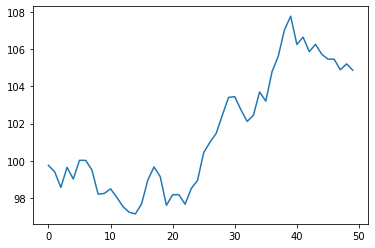

In [24]:
a, b, c, d = next(iter(data_loader_train))
plt.plot(a[0])

In [25]:
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

In [26]:
# Evaluation In-Sample

_ ,model_loss = test(data_loader_train, cn, criterion)

l = len(data_loader_train.dataset)
x, x_inc, payoff, price = data_loader_train.dataset[:l]

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(model_loss)
print(delta_loss)

tensor(1.9985, grad_fn=<MseLossBackward>)
tensor(0.2765)


In [11]:
# Evaluation Out-Sample
data_loader_test = DataLoader(dt_test, batch_size=20, shuffle=True)

_ ,model_loss = test(data_loader_test, cn, criterion)

l = len(data_loader_test.dataset)
x, x_inc, payoff, price = data_loader_test.dataset[:l]

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(model_loss)
print(delta_loss)

tensor(1.9803, grad_fn=<MseLossBackward>)
tensor(0.2702)


In [23]:
# normalize everything by the strike
initial_value / strike

0.9975609756097561